# Feature Importance 

Code which, given a trained model, calculates the importance of features on unseen data. Inspired by https://scikit-learn.org/stable/modules/permutation_importance.html

In [2]:
import numpy as np 
import scipy as sp 
from sklearn.inspection import permutation_importance 

import tensorflow as tf 
import pandas as pd

import matplotlib.pyplot as plt 

Useful functions

In [3]:
difference = 0.0

# Some useful functions

# Routine to normalize between 0 and 1 (Following the atmospheric turbulence paper)

def norm_data(x):
    minX = np.min(x[np.nonzero(x)])
    maxX = np.max(x[np.nonzero(x)])
    normed = (x - minX)/(maxX - minX)
    
    # Zero out any values that are above 1
    normed[normed>1] =  0
    
    return normed, minX, maxX

# Routine to ... UNNORMALIZE. This is done to convert the data back to the original time scale. 

def unnorm_data(x, minX, maxX):
    unnorm_fac = (maxX - minX)
    print(unnorm_fac)
    return x*unnorm_fac + minX
    
# This applies a rolling average on the dataset 

# Function taken from a learnpython article

def roll_average(input_data, window_size):
    result = []
    for i in range(len(input_data) - window_size + 1):
        window = input_data[i:i+window_size]
        window_average = sum(window)/window_size
        result.append(window_average)
        
    return np.array(result)
    
def rollify_training(X, window_size):
    X_features = X.shape[2]
    
    X_roll_len = X.shape[1] - window_size + 1
    
    X_roll = np.empty((len(X), X_roll_len, X_features))
    
    for ii in range(len(X)):
        for jj in range(X_features):
            X_roll[ii,:,jj] = roll_average(X[ii,:,jj], window_size)
            
    return X_roll

# This function batches up consecutive pieces of data


def batch_consecutive(direc_name, iterate=1):
    directory_list = [name for name in os.listdir(f'{direc_name}/.')]
    
    prev_int = int(os.path.splitext(directory_list[0])[0])
    total_batches = []
    consecutive_batch = []
    
    for jj, name in enumerate(directory_list):
        name_int = int(os.path.splitext(name)[0])
        if (name_int-prev_int==iterate) or (name_int-prev_int==0):
            consecutive_batch.append(name)
            prev_int = name_int

        elif(name_int-prev_int>iterate):
            total_batches.append(consecutive_batch)
            consecutive_batch = []
            consecutive_batch.append(name)
            prev_int = name_int
        
    total_batches.append(consecutive_batch)
    return total_batches

    
def mse_mod(y_true, y_pred):

    loss = K.mean(K.square(y_pred - y_true), axis=-1)
    loss_true = tf.reduce_mean(loss)
    
    # We add a small epsillion to the MSE. This makes it so that we avoid crazy losses
    return loss_true + 1e-8

def hours_to_int(x):
    if x[0:-2]=='':
        return 0
    else:
        return int(x[0:-2])
    
def convert_to_sec(minute, hour):
    return 3600*hour + 60*minute


def load_data(direc_name, time_steps, input_list, window_size, num_of_examples, full_time_series=False, pad_output_zeros = True,  forecast_len=1, time_res=1):

    total_input = []
    total_output = []
    
    # Files expected
    
    directory_list = [name for name in os.listdir(f'{direc_name}/.')]
    num_features = len(input_list)
    print(num_features)
    if ('day' in input_list):
        num_features+= 1
    if ('time' in input_list):
        num_features+= 1
    print(num_features)
    
    
    print(f'Parameter List: {input_list}')
    
    num_of_zeros = 0
    
    for jj, name in enumerate(directory_list):
    
       # print("****")
        
        #print(jj)
        
        df = pd.read_csv(f'{direc_name}/{name}')
        #print(name)
        #print(name)
        # rename columns to something more decipherable 
        df = df.rename(columns={'Temp °C':'temperature', 'RH %':'relative_humidity', 'kJ/m^2':'solar_radiation', 'Wind Speed m/s':'wind_speed', 'SOG cm':'SOG','Pressure hPa':'pressure', 'hr:min (UTC)':'time', 'Julian day (UTC)': 'day'})
        # Map the day into a unit circle, and create 'day_sin'  and 'day_cos' to define the x and y components in the circle. 
        df['day_sin'] = np.sin(df['day']*(2.*np.pi/365))
        df['day_cos'] = np.cos(df['day']*(2.*np.pi/365))
        # For time, we convert to string representation
        df['time']=df['time'].astype(str)
        df['minute'] = df['time'].apply(lambda x: int(x[-2:]))
        df['hour'] = df['time'].apply(lambda x: hours_to_int(x))
        df['second'] = convert_to_sec(df['minute'], df['hour'])
        # Map the time into a unit circle 
        df['time_sin']= np.sin(df['second']*(2.*np.pi/86400))
        df['time_cos']= np.cos(df['second']*(2.*np.pi/86400))

        #print(df.columns)
        #input()
        
        # If the prior/future CN2 columns have zero values, then continue to next iteration 
        if(df['CN2']==0).any() or (df['CN2 Future']==0).any():
             #print(jj)
             num_of_zeros += 1
             print(f'number of zeros: {num_of_zeros}')
             print('error data detected. Skipping to next value')
             continue
        
        dataset_weather = np.empty((time_steps, num_features))
        dataset_output = np.empty((output_len, 1))
        
        ###### INPUT DATA #######
        ii= 0
        kk= 0 # index for column
        
        while ii < num_features:
           # print(ii)
            colName = input_list[kk]
            if(colName=='day'):
             
                # include both day_sin and day_cos
                
                dataset_weather[:,ii] = df['day_sin'].to_numpy()
                ii += 1
                dataset_weather[:,ii] = df['day_cos'].to_numpy()
                
            elif(colName=='time'):
                
                # Include both time_sin and time_cos
                
                dataset_weather[:,ii] = df['time_sin'].to_numpy()
                ii += 1
                dataset_weather[:,ii] = df['time_cos'].to_numpy()
               
                
            
            elif(colName=='CN2'):
                dataset_weather[:,ii] = np.log10(df[colName].to_numpy())
            else:

                dataset_weather[:,ii] = df[colName].to_numpy()
            kk += 1
            ii += 1
            
                
        ###### OUTPUT DATA #######
        
        # In the 0th output, CN2 FUTURE
        
        # First, let's consider every example up to forecast length 
        nn_output  = np.log10(df["CN2 Future"][:forecast_len].to_numpy())
        
        # Next, only consider every time_res example in the final output
        dataset_output[:,0] = nn_output[np.mod(np.arange(len(nn_output)),time_res) == 0]
        
        # Let's consider wildly varying output data. Compute the difference between maximum and minimum. 
        max_CN2 = np.max(np.abs(dataset_output[:,0]))
        min_CN2 = np.min(np.abs(dataset_output[:,0]))
        diff = np.abs(max_CN2 - min_CN2)
        
        if (diff >= -1.0):
            total_input.append(dataset_weather)
            total_output.append(dataset_output)
            
        if (jj%500==0):
            print(f"Data loaded:{jj}")
            
        if (jj>num_of_examples):
            print("Finished loading data!")
            break;
            
        
       # print(dataset_output)
       # print("****")
    
    total_input = np.array(total_input)
    total_output = np.array(total_output)
    
    if(full_time_series):
        return total_input, total_output
    else:
        return total_input, total_output[:,0]
    

Load the model 

In [4]:
full_model = 'fullModel_FebMar_7318'

loaded_model = tf.keras.models.load_model(f'models/{full_model}', custom_objects={'mse_mod':mse_mod})

Load the data

In [5]:
import os 
import pickle as pkl 

input_features = ['relative_humidity', 'solar_radiation', 'temperature', 'pressure', 'wind_speed', 'SOG', 'time', 'day', 'CN2']

number_of_features = len(input_features)
if ('day' in input_features):
    number_of_features+= 1
if ('time' in input_features):
    number_of_features+= 1

# For consistency, normalize the data wrt training. This is for the 15 min, 6 hour res network w/ old norm

# minOut_X = [16.29781, -0.3995518, -16.46344155742847,  -18.04353]
# maxOut_X = [99.52488, 71.5599, -13.749579997691106,  32.07004]

#minTrain = [16.29781, -0.3995518, -18.04353, 981.8908, 0.0001, -3.174637, -1.0, -1.0, -0.9999907397361901, -0.9441875088341996, -16.46344155742847]
#maxTrain =  [99.52488, 71.5599, 32.07004, 1026.827, 17.12397, 6997.0, 1.0, 1.0, 0.995918996147179, 1.0, -13.749579997691106]

time_len = 720
time_res = 15
forecast_len = 360
output_len = int(forecast_len/time_res)
num_of_examples = 4e4
window_size = 1
full_time_series = True
pad_output_zeros = False 

direc_name = f"dataset/OneMinResolution_OneHourWindow" # yaml worthy

#X,y = load_data(direc_name, time_len, input_features, window_size, num_of_examples, full_time_series, pad_output_zeros, forecast_len, time_res)

with open(f'dataset/{full_model}_testData.pkl', 'rb') as f:
    X_test, y_test = pkl.load(f)

The permutation function isn't natively compatible with tensorflow, so we build our own! 

In [7]:
# input_features = ['Relative Humidity', 'Solar Radiation', 'Temperature', 'Pressure', 'Wind Speed', 'SOG', '$\sin(time)$', '$\cos(time)$', '$\sin(day)$', '$\cos(day)$', '$C_{n}^{2}$']

In [8]:
# permutes feature_index column of a given dataset X. We can permute multiple examples at once using the "num_examples" function

def data_corrupter(X, num_examples, feature_index):
    dark_X = np.copy(X)
    temp = dark_X
    shuffleInts = np.arange(720)
    np.random.shuffle(shuffleInts)
    if (len(feature_index)>1):
        dark_X[0:num_examples,:,feature_index] = dark_X[0:num_examples, shuffleInts[:,None], feature_index]
    else:
        dark_X[0:num_examples,:,feature_index] = dark_X[0:num_examples, shuffleInts, feature_index]
    return dark_X 

# Rather than permuting the feature_index column, we remove it entirely by "zero"ing it out. 

def data_subtractor(X, num_examples, feature_index):
    empty_X = np.copy(X)
    empty_X[0:num_examples,:,feature_index] = 0
    
    return empty_X
    
def rms(y_true, y_pred): # This'll function as our score 
    root_mean = np.sqrt((y_true - y_pred)**2)
    return root_mean 

def compute_score(model, X, y, num_examples, num_repetitions, permute=True, subtract=False, multiple=False):
    X_shape = np.shape(X)
    if (multiple): # (pressure, temp), (pressure, temp, wind speed), (pressure, temp, rel. humidity), (pressure, temp, relative humidity)
        num_of_features=[[2,3], [2,3,4], [2,3,0], [2,3,4,0]]
    else:
        num_of_features = np.arange(X_shape[-1])

    num_of_examples = X_shape[0]
    
    len_num_features = len(num_of_features)
    print(len_num_features)
    # Create a array that stores the scores for each feature
    
    scores = np.zeros((len_num_features, num_repetitions))
    
    # Now let's make the model predict w/ corrupted data, and compute the score. 
    
    for ii, feat in enumerate(num_of_features):
        print(feat)
        for jj in range(num_repetitions): 
            print(jj)
            # Corrupt X. Either we permute the iith column, or we zero it out.
            if (permute):
                dark_X = data_corrupter(X, num_examples, feat)
            elif(subtract):
                dark_X = data_subtractor(X, num_examples, feat)
            #dark_X = data_corrupter(X, num_examples, ii)
            dark_X_extend = dark_X[0:num_examples,:,:]
            preds = model.predict(dark_X_extend, verbose=False)
            preds = np.array(preds)
            y_true = y[0:num_examples,:]
            # Compute the RMSE
            score = np.mean(rms(preds,y_true))
            scores[ii, jj] = score
            print(score)
    return scores

#theScores = compute_score(loaded_model, X_test, y_test, 1000, 3, multiple=True)

This might take some time to compute; we save the values we got for future reference. 

In [9]:
np.savetxt('scores_1000_3_correlation', theScores)
#mean_scores = np.mean(theScores, axis=1)
#print(mean_scores)

NameError: name 'theScores' is not defined

If you've already done the calcs, load the score values. 

In [10]:
theScores = np.loadtxt('scores_1000_3_correlation')

The time is nigh to calculate the permutation importance 

In [12]:
def compute_importance(num_examples, X, y, model, scores):
    X_shape = np.shape(X)
    num_of_features = X_shape[-1]
    num_of_examples = X_shape[0]
    
    # Start by computing the performance of the OG model
    
    light_X_extend = X[0:num_examples,:,:]
    preds = model.predict(light_X_extend, verbose=False)
    preds = np.array(preds)
    y_true = y[0:num_examples,:]
    
    # Compute the RMSE
    light_score = np.mean(rms(preds,y_true))
    print(light_score)
    
    # importance metrics
    importance_div = scores/light_score 
    importance_sub = scores - light_score 
    
    # Compute the mean and variance for each metric  
    importance_div_mean = np.mean(importance_div, axis=1)
    importance_div_var = np.var(importance_div, axis=1)
    
    importance_sub_mean = np.mean(importance_sub, axis=1)
    importance_sub_var = np.var(importance_sub, axis=1)
    
    print(f"Importance (division): {importance_div_mean}")
    print(f"Importance (subtraction): {importance_sub_mean}")
    
    return importance_div_mean, importance_div_var, importance_sub_mean, importance_sub_var
    
importance_div_mean, importance_div_var, importance_sub_mean, importance_sub_var = compute_importance(1000, X_test, y_test, loaded_model, theScores)

0.01345992188276089
Importance (division): [1.91799161 2.36780139 3.53345658 4.15090233]
Importance (subtraction): [0.0123561  0.0184105  0.03410013 0.0424109 ]


In [13]:
importance_div_var

array([0.00273492, 0.00199443, 0.01265911, 0.00729368])

In [49]:
plt.rcParams.update(plt.rcParamsDefault)

Make a sicknasty bar plot

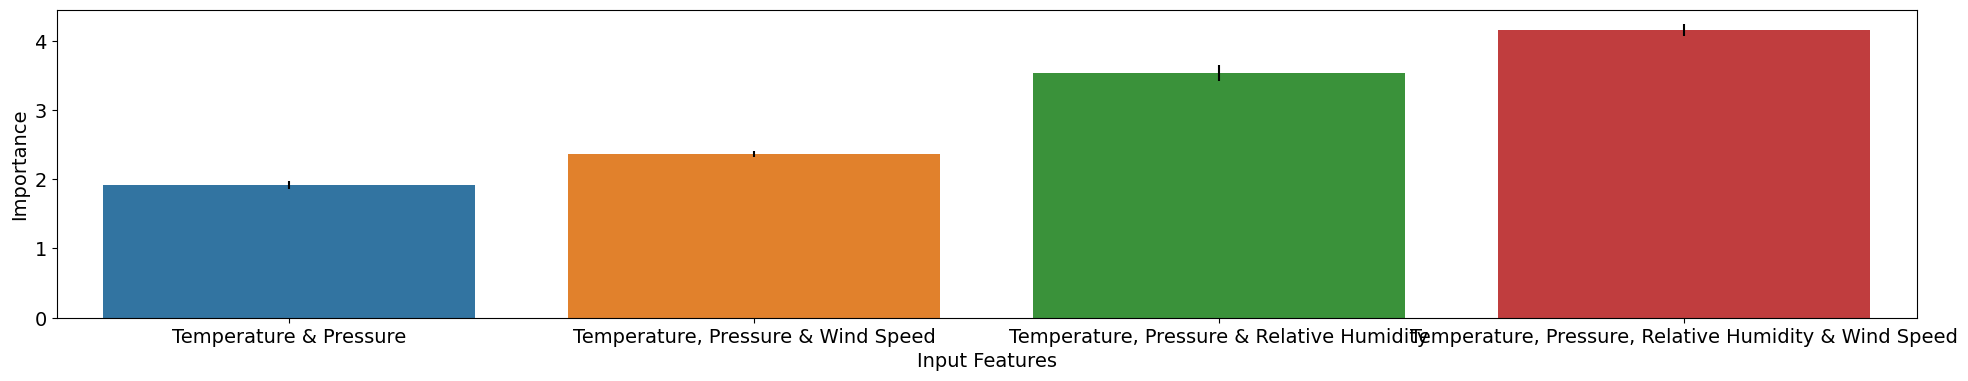

In [14]:
import seaborn as sns

#input_features = ['Relative Humidity', 'Solar Radiation', 'Temperature', 'Pressure', 'Wind Speed', 'SOG', '$\sin(time)$', '$\cos(time)$', '$\sin(day)$', '$\cos(day)$', '$C_{n}^{2}$']
input_features = ['Temperature & Pressure', 'Temperature, Pressure & Wind Speed', 'Temperature, Pressure & Relative Humidity', 'Temperature, Pressure, Relative Humidity & Wind Speed' ]

data = {
    
    'Input Features' : input_features,
    'Importance': importance_div_mean,
    'importance_var': np.sqrt(importance_div_var)
}

df = pd.DataFrame(data)
# Set font sizes
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

fig, ax = plt.subplots(figsize=(24,4))
# Set font sizes
ax=sns.barplot(x='Input Features', y='Importance', data=df, yerr=df['importance_var'])
#ax.set_xlabel(fontsize=22)
#plt.show()

In [70]:
plt.savefig('feature_importance.pdf', format='pdf', bbox_inches='tight')